In [12]:
!git clone https://github.com/nprksh/landslide-mapping-with-cnn.git

Cloning into 'landslide-mapping-with-cnn'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 109 (delta 21), reused 21 (delta 21), pack-reused 86
Receiving objects: 100% (109/109), 21.25 MiB | 22.67 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [18]:
%cd "/content/landslide-mapping-with-cnn/"

/content/landslide-mapping-with-cnn


In [19]:
!git lfs fetch --all

fetch: 2 object(s) found, done.
fetch: Fetching all references...


In [20]:
import os
import sys
import itertools
import random

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

In [21]:
import numpy as np
import csv
import sys
import os
from osgeo import gdal, gdalnumeric


NP2GDAL_CONVERSION = {
  "uint8": gdal.GDT_Byte,
  "int8": gdal.GDT_Byte,
  "uint16": gdal.GDT_UInt16 ,
  "int16": gdal.GDT_Int16,
  "uint32": gdal.GDT_UInt32,
  "int32": gdal.GDT_Int32,
  "float32": gdal.GDT_Float32,
  "float64": gdal.GDT_Float64,
#   "complex64": gdal.GDT_Int16,
#   "complex128": gdal.GDT_Int16,
}


def readGDAL2numpy(rasterPath, return_geoInformation = False):
    try:
        ds = gdal.Open(rasterPath)
    except RuntimeError:
        print('Unable to open input file')
        sys.exit(1)

    data = gdalnumeric.LoadFile(rasterPath, False)
    noDataVal = ds.GetRasterBand(1).GetNoDataValue()
    try:
        if data.dtype in ['float16', 'float32', 'float64'] and noDataVal is not None:
            data[data == noDataVal] = np.NaN
    except:
        print("Issue in no data value")

    if len(data.shape) == 3:
        data = np.transpose(data , (1, 2, 0))

    if return_geoInformation == False:
        return data
    else:
        geoTransform = ds.GetGeoTransform()
        projection = ds.GetProjection()
        return data, geoTransform, projection



def writeNumpyArr2Geotiff(outputPath, data, geoTransform = None, projection = None, GDAL_dtype = None, noDataValue = None, colorTable = None):
    nscn, npix = data.shape

    if GDAL_dtype is None:
        GDAL_dtype = NP2GDAL_CONVERSION[data.dtype.name]

    if np.isnan(data).any() and noDataValue is not None:
        print('Here1')
        data[np.isnan(data)] = noDataValue

    ds_new = gdal.GetDriverByName('GTiff').Create(outputPath, npix, nscn, 1, GDAL_dtype)

    if geoTransform != None:
        ds_new.SetGeoTransform(geoTransform)

    if projection != None:
        ds_new.SetProjection(projection)

    outBand = ds_new.GetRasterBand(1)
    outBand.WriteArray(data)

    if noDataValue != None:
        ds_new.GetRasterBand(1).SetNoDataValue(noDataValue)

    if colorTable != None:
        ds_new.GetRasterBand(1).SetRasterColorTable(colorTable)

    # Close dataset
    ds_new.FlushCache()
    ds_new = None
    outBand = None



def newGeoTransform(geoTransform, maskBounds):
    newGeoTransform = (geoTransform[0]+ maskBounds['xMin'] * geoTransform[1],
                   geoTransform[1],
                   geoTransform[2],
                   geoTransform[3] + maskBounds['yMin'] * geoTransform[5],
                   geoTransform[4],
                   geoTransform[5])
    return newGeoTransform



def bbox(img):
    scn = np.any(img, axis=1)
    pix = np.any(img, axis=0)
    scnMin, scnMax = np.where(scn)[0][[0, -1]]
    pixMin, pixMax = np.where(pix)[0][[0, -1]]
    return [scnMin, scnMax, pixMin, pixMax]



def getBoundingBox(rasterPath, returnBinaryMask = False):
    image, geoT, proj = readGDAL2numpy(rasterPath, return_geoInformation = True)

    yMin, yMax, xMin, xMax = bbox(image)

    if returnBinaryMask:
        maskImage = image[yMin : yMax, xMin : xMax]
        maskGeoT  = newGeoTransform(geoT, {'xMin' : xMin, 'yMin' : yMin})
        return [yMin, yMax, xMin, xMax], maskImage, maskGeoT, proj
    else:
        return [yMin, yMax, xMin, xMax]

In [3]:
import sys
path_m ="/content/"
sys.path.insert(0,path_m)

In [22]:
import gdalCommonUtils as gutils
import IO as io
import tileHelpers as tileHelper

In [23]:
import tensorflow as tf
from tensorflow.keras import models
from osgeo import gdal, ogr, osr
import cv2
import os; #os.environ['PROJ_LIB'] = '/home/geosys/mambaforge/envs/tflsdf/share/proj'

In [6]:
print('TF Version -->', tf.__version__)
print('GDAL Version -->', gdal.__version__)
print('OPEN CV Version -->', cv2.__version__)

TF Version --> 2.15.0
GDAL Version --> 3.6.4
OPEN CV Version --> 4.8.0


In [24]:
print('CURRENT WORKING DIR -->', os.getcwd())

CURRENT WORKING DIR --> /content/landslide-mapping-with-cnn


In [8]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [25]:
PROJECT_PATH = '.'
OUTPUT_PATH  = os.path.join(*[PROJECT_PATH, 'Mapping_results'])

io.createDirectory(OUTPUT_PATH, emptyExistingFiles = True, verbose = True)

./Mapping_results --> Folder exists!!!
3 files found in ./Mapping_results --> Will be deleted.


In [27]:
# !unzip "/content/drive-download-20240512T112701Z-001.zip"

In [28]:
import os
#read all dem file paths and store in list
preimg=[]
postimg=[]
hsimg=[]
slpimg=[]
demfp=[]
folderdem="/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021"
hsf="/content/landslide-mapping-with-cnn/hs_resamp_reproj_2021"
sf="/content/landslide-mapping-with-cnn/slope_resamp_reproj_2021"
pref="/content/landslide-mapping-with-cnn/ClipImagePre_2021"
postf="/content/landslide-mapping-with-cnn/ClipImagePost_2021"

for file in os.listdir(folderdem):
    if file.endswith(".tif"):
        fptemp=(os.path.join(folderdem, file))
        # ik+=1
        demfp.append(fptemp)

print(demfp)

for file in os.listdir(hsf):
    if file.endswith(".tif"):
        fptemp=(os.path.join(hsf, file))
        # ik+=1
        hsimg.append(fptemp)

print(hsimg)

for file in os.listdir(sf):
    if file.endswith(".tif"):
        fptemp=(os.path.join(sf, file))
        # ik+=1
        slpimg.append(fptemp)

print(slpimg)
for file in os.listdir(pref):
    if file.endswith(".tif"):
        fptemp=(os.path.join(pref, file))
        # ik+=1
        preimg.append(fptemp)

print(preimg)

for file in os.listdir(postf):
    if file.endswith(".tif"):
        fptemp=(os.path.join(postf, file))
        # ik+=1
        postimg.append(fptemp)

print(postimg)




['/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222035DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222024DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222026DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222025DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222044DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222007DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222016DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222048DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content/landslide-mapping-with-cnn/dem_resamp_reproj_2021/96222046DEM_WGS84_reproj_2021__resamp_2021_.tif', '/content

In [ ]:
BASE_RESOLUTION = 10

SAVED_MODEL = os.path.join(*[PROJECT_PATH, 'M_ALL_006.hdf5'])


RAW_DATA_PATH = os.path.join(*[PROJECT_PATH, 'data_taiwan', 'data_taiwan'])

DEM_PATH   = os.path.join(*[RAW_DATA_PATH, 'DEM', 'DEMtaiwan.tif'])
HS_PATH    = os.path.join(*[RAW_DATA_PATH, 'DEM', 'HillDEM.tif'])
SLOPE_PATH = os.path.join(*[RAW_DATA_PATH, 'DEM', 'SlopeSampledDEM.tif'])

POST_IMAGE_PATH = os.path.join(*[RAW_DATA_PATH, 'fromOptical',  '96222016DEM_WGS84_0tci_post_S2A_51RUH_20211111_1_L2A.tif'])
PRE_IMAGE_PATH  = os.path.join(*[RAW_DATA_PATH, 'fromOptical',  '96222016DEM_WGS84_0tci_pre_S2B_51RUH_20210907_0_L2A.tif'])
NO_DATA_MASK    = os.path.join(*[RAW_DATA_PATH, 'noDataMask',   'SNOW_CLOUD_MASK_010.tif'])

In [ ]:
assert os.path.isfile(SAVED_MODEL)

assert os.path.isfile(DEM_PATH)
assert os.path.isfile(HS_PATH)
assert os.path.isfile(SLOPE_PATH)

assert os.path.isfile(POST_IMAGE_PATH)
assert os.path.isfile(PRE_IMAGE_PATH)

TEST_ROI_PATH   = os.path.join(*[RAW_DATA_PATH, 'testBoundary', 'Test_%s.tif'%str(BASE_RESOLUTION).zfill(3)])
assert os.path.isfile(TEST_ROI_PATH)

In [29]:
def open_and_rescale_to_baseResolution(img_path, shape, crop_to_bbox=None):
    img = gutils.readGDAL2numpy(img_path)
    img = tileHelper.rescaleInput(img, shape)
    if crop_to_bbox is not None:
        yMin, yMax, xMin, xMax = bbox
        img = img[yMin: yMax, xMin: xMax]
    return img

In [ ]:
bbox, binaryMask, newGeoT, proj = gutils.getBoundingBox(rasterPath = TEST_ROI_PATH, returnBinaryMask = True)
nscn, npix = binaryMask.shape


## generate a mask from no data file
if os.path.isfile(NO_DATA_MASK):
    maskImage = 1 - open_and_rescale_to_baseResolution(img_path=NO_DATA_MASK, shape=(nscn, npix), crop_to_bbox=bbox)
else:
    maskImage = np.zeros(shape=(nscn, npix))


## append in mask file where test area Image == 0
maskImage[binaryMask == 0] = 0

maskFileName = os.path.join(*[OUTPUT_PATH, 'MaskImage.tif'])
gutils.writeNumpyArr2Geotiff(maskFileName, 1-maskImage, newGeoT, proj, GDAL_dtype=gdal.GDT_Byte, noDataValue=0)


In [ ]:
!which python

/home/geosys/mambaforge/envs/tflsdf/bin/python


In [ ]:
imageSize = 224
overlapFactor = 2
fetchSize = int(imageSize / 2)
skipPx = int(imageSize / overlapFactor)

## Generates all possible bounding boxes for tiling
## The center location of every box is the anchor point defined in list 'locXY'
Y = [y for y in range(fetchSize + 1, nscn - fetchSize - 1, skipPx)]
X = [x for x in range(fetchSize + 1, npix - fetchSize - 1, skipPx)]
locXY = list(itertools.product(X, Y))

## extract all the valid boxes
## i.e. which are in the study area and landslide mask
## Mask Image == 1 for valid regions
## threshold of 0.75 --> 75% region is valid
validLocXY = [currLoc for currLoc in locXY if tileHelper.isValidTile(maskImage, imageSize, currLoc, threshold=0.50)]

In [ ]:
postImage = open_and_rescale_to_baseResolution(img_path=POST_IMAGE_PATH, shape=(nscn, npix), crop_to_bbox=bbox)
preImage  = open_and_rescale_to_baseResolution(img_path=PRE_IMAGE_PATH,  shape=(nscn, npix), crop_to_bbox=bbox)

hs    = open_and_rescale_to_baseResolution(img_path=HS_PATH,    shape=(nscn, npix), crop_to_bbox=bbox)
slope = open_and_rescale_to_baseResolution(img_path=SLOPE_PATH, shape=(nscn, npix), crop_to_bbox=bbox)

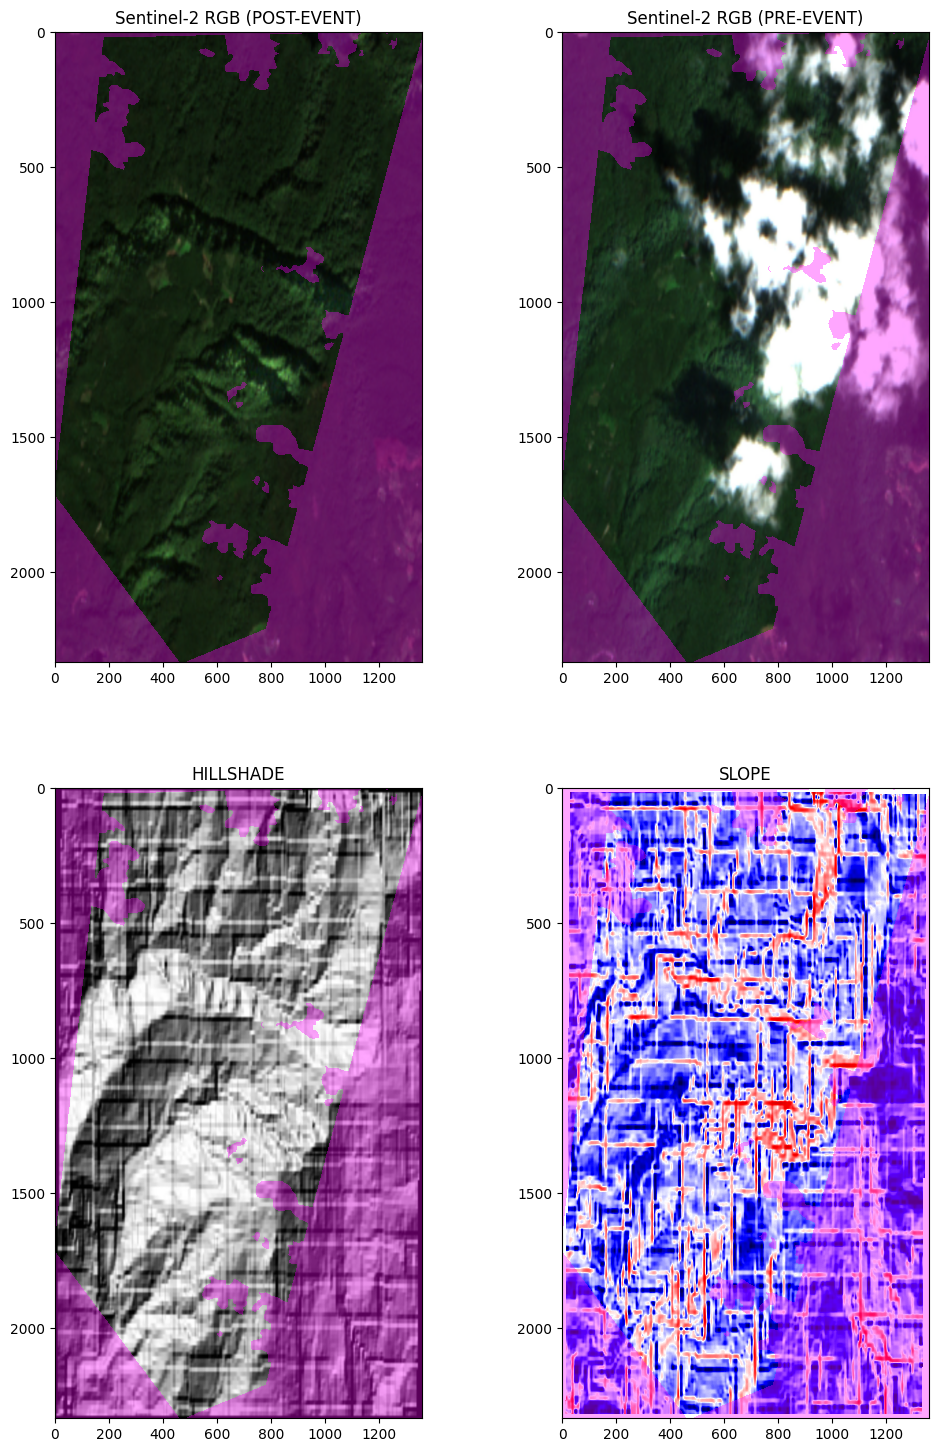

In [ ]:
showMask = True

# display images
fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(12,18))

ax[0,0].imshow(postImage)
ax[0,0].set_title('Sentinel-2 RGB (POST-EVENT)')

ax[0,1].imshow(preImage)
ax[0,1].set_title('Sentinel-2 RGB (PRE-EVENT)')

ax[1,0].imshow(hs, cmap='gray', vmin=0, vmax=255)
ax[1,0].set_title('HILLSHADE')

ax[1,1].imshow(slope, cmap='seismic', vmin=0, vmax=90)
ax[1,1].set_title('SLOPE')

if showMask:
    maskForDisplay = 1 - maskImage.copy()
    maskForDisplay = np.float32(maskForDisplay)
    maskForDisplay[maskForDisplay == 0] = np.nan

    ax[0,0].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[0,1].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[1,0].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[1,1].imshow(maskForDisplay, alpha=0.35, cmap='cool', vmin=0, vmax=1)

plt.show()

In [30]:
def normalize(image):
    new_img = np.array(image, dtype = np.float32)
    new_img /= 127.5
    new_img -= 1.
    return new_img


def normalizeArray(image):
    # post image
    image[ : , :, :3] = normalize(image[ : , :, :3])

    # pre image
    image[ : , :, 3:6] = normalize(image[ : , :, 3:6])

    # HS image
    image[ : , :, 6:7] = normalize(image[ : , :, 6:7])

    # Slope Image
    image[ : , :, -1] = (image[ : , :, -1] / 45.0) - 1.0

    return image

In [ ]:
stack = []

stack.append(postImage)
stack.append(preImage)
stack.append(hs[:, :, np.newaxis])
stack.append(slope[:, :, np.newaxis])

testImage = np.concatenate(stack, axis=2)
del stack

testImage = np.nan_to_num(testImage)
testImage = normalizeArray(testImage)

inputChannel = testImage.shape[2]

predictMask = np.zeros((testImage.shape[0], testImage.shape[1]), np.uint8)

fetchSize_half = int(fetchSize/2)

In [ ]:
SAVED_MODEL

'./M_ALL_006.hdf5'

In [ ]:
model = models.load_model(SAVED_MODEL, compile=False)

model.compile(optimizer='adam', loss='binary_crossentropy')

2024-04-30 21:35:46.171569: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
for x, y in tqdm(validLocXY):

    img = testImage[y - fetchSize: y + fetchSize, x - fetchSize: x + fetchSize, :]

    img = img.reshape(1, imageSize, imageSize, inputChannel)
    predict_image_list = [img[:, :, :, 3:6],  # pre-image
                          img[:, :, :, :3],  # post-image
                          img[:, :, :, -2:]  # topo-image
                            ]
    predicted_label = model.predict(predict_image_list)[0][0]

    predictMask[y - fetchSize_half: y + fetchSize_half, x - fetchSize_half: x +
        fetchSize_half] = predicted_label[fetchSize_half: -fetchSize_half, fetchSize_half: -fetchSize_half, 0] * 100

predictMask = predictMask * maskImage
gutils.writeNumpyArr2Geotiff(OUTPUT_PATH + '/Predict_LS_Conf.tif', predictMask, newGeoT, proj, GDAL_dtype= gdal.GDT_Byte, noDataValue = 0)

  0%|          | 0/151 [00:00<?, ?it/s]

1/1 [==============================] - 1s 866ms/step


  1%|          | 1/151 [00:00<02:15,  1.10it/s]

1/1 [==============================] - 0s 148ms/step


  1%|▏         | 2/151 [00:01<01:10,  2.12it/s]

1/1 [==============================] - 0s 151ms/step


  2%|▏         | 3/151 [00:01<00:49,  2.99it/s]

1/1 [==============================] - 0s 146ms/step


  3%|▎         | 4/151 [00:01<00:39,  3.74it/s]

1/1 [==============================] - 0s 145ms/step


  3%|▎         | 5/151 [00:01<00:33,  4.35it/s]

1/1 [==============================] - 0s 158ms/step


  4%|▍         | 6/151 [00:01<00:30,  4.72it/s]

1/1 [==============================] - 0s 143ms/step


  5%|▍         | 7/151 [00:01<00:28,  5.11it/s]

1/1 [==============================] - 0s 145ms/step


  5%|▌         | 8/151 [00:02<00:26,  5.38it/s]

1/1 [==============================] - 0s 144ms/step


  6%|▌         | 9/151 [00:02<00:25,  5.59it/s]

1/1 [==============================] - 0s 145ms/step


  7%|▋         | 10/151 [00:02<00:24,  5.74it/s]

1/1 [==============================] - 0s 147ms/step


  7%|▋         | 11/151 [00:02<00:24,  5.78it/s]

1/1 [==============================] - 0s 147ms/step


  8%|▊         | 12/151 [00:02<00:23,  5.86it/s]

1/1 [==============================] - 0s 151ms/step


  9%|▊         | 13/151 [00:02<00:23,  5.87it/s]

1/1 [==============================] - 0s 141ms/step


  9%|▉         | 14/151 [00:03<00:22,  6.00it/s]

1/1 [==============================] - 0s 148ms/step


 10%|▉         | 15/151 [00:03<00:22,  6.00it/s]

1/1 [==============================] - 0s 140ms/step


 11%|█         | 16/151 [00:03<00:22,  6.09it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█▏        | 17/151 [00:03<00:21,  6.10it/s]

1/1 [==============================] - 0s 143ms/step


 12%|█▏        | 18/151 [00:03<00:21,  6.12it/s]

1/1 [==============================] - 0s 144ms/step


 13%|█▎        | 19/151 [00:03<00:21,  6.10it/s]

1/1 [==============================] - 0s 143ms/step


 13%|█▎        | 20/151 [00:04<00:21,  6.13it/s]

1/1 [==============================] - 0s 145ms/step


 14%|█▍        | 21/151 [00:04<00:21,  6.13it/s]

1/1 [==============================] - 0s 145ms/step


 15%|█▍        | 22/151 [00:04<00:21,  6.13it/s]

1/1 [==============================] - 0s 144ms/step


 15%|█▌        | 23/151 [00:04<00:20,  6.14it/s]

1/1 [==============================] - 0s 147ms/step


 16%|█▌        | 24/151 [00:04<00:20,  6.09it/s]

1/1 [==============================] - 0s 149ms/step


 17%|█▋        | 25/151 [00:04<00:20,  6.06it/s]

1/1 [==============================] - 0s 151ms/step


 17%|█▋        | 26/151 [00:05<00:20,  5.99it/s]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 27/151 [00:05<00:20,  6.00it/s]

1/1 [==============================] - 0s 145ms/step


 19%|█▊        | 28/151 [00:05<00:20,  6.03it/s]

1/1 [==============================] - 0s 150ms/step


 19%|█▉        | 29/151 [00:05<00:20,  6.00it/s]

1/1 [==============================] - 0s 147ms/step


 20%|█▉        | 30/151 [00:05<00:20,  6.03it/s]

1/1 [==============================] - 0s 160ms/step


 21%|██        | 31/151 [00:05<00:20,  5.88it/s]

1/1 [==============================] - 0s 145ms/step


 21%|██        | 32/151 [00:06<00:19,  5.96it/s]

1/1 [==============================] - 0s 149ms/step


 22%|██▏       | 33/151 [00:06<00:19,  5.96it/s]

1/1 [==============================] - 0s 148ms/step


 23%|██▎       | 34/151 [00:06<00:19,  5.98it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██▎       | 35/151 [00:06<00:19,  6.01it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██▍       | 36/151 [00:06<00:19,  6.04it/s]

1/1 [==============================] - 0s 147ms/step


 25%|██▍       | 37/151 [00:06<00:18,  6.03it/s]

1/1 [==============================] - 0s 151ms/step


 25%|██▌       | 38/151 [00:07<00:18,  5.99it/s]

1/1 [==============================] - 0s 147ms/step


 26%|██▌       | 39/151 [00:07<00:18,  6.01it/s]

1/1 [==============================] - 0s 146ms/step


 26%|██▋       | 40/151 [00:07<00:18,  6.02it/s]

1/1 [==============================] - 0s 150ms/step


 27%|██▋       | 41/151 [00:07<00:18,  6.00it/s]

1/1 [==============================] - 0s 150ms/step


 28%|██▊       | 42/151 [00:07<00:18,  5.99it/s]

1/1 [==============================] - 0s 148ms/step


 28%|██▊       | 43/151 [00:07<00:18,  5.96it/s]

1/1 [==============================] - 0s 144ms/step


 29%|██▉       | 44/151 [00:08<00:17,  6.01it/s]

1/1 [==============================] - 0s 153ms/step


 30%|██▉       | 45/151 [00:08<00:17,  5.97it/s]

1/1 [==============================] - 0s 144ms/step


 30%|███       | 46/151 [00:08<00:17,  6.03it/s]

1/1 [==============================] - 0s 148ms/step


 31%|███       | 47/151 [00:08<00:17,  6.03it/s]

1/1 [==============================] - 0s 146ms/step


 32%|███▏      | 48/151 [00:08<00:17,  6.05it/s]

1/1 [==============================] - 0s 148ms/step


 32%|███▏      | 49/151 [00:08<00:16,  6.05it/s]

1/1 [==============================] - 0s 147ms/step


 33%|███▎      | 50/151 [00:09<00:16,  6.05it/s]

1/1 [==============================] - 0s 147ms/step


 34%|███▍      | 51/151 [00:09<00:16,  6.03it/s]

1/1 [==============================] - 0s 147ms/step


 34%|███▍      | 52/151 [00:09<00:16,  6.03it/s]

1/1 [==============================] - 0s 146ms/step


 35%|███▌      | 53/151 [00:09<00:16,  6.04it/s]

1/1 [==============================] - 0s 148ms/step


 36%|███▌      | 54/151 [00:09<00:16,  6.04it/s]

1/1 [==============================] - 0s 147ms/step


 36%|███▋      | 55/151 [00:09<00:15,  6.04it/s]

1/1 [==============================] - 0s 147ms/step


 37%|███▋      | 56/151 [00:10<00:15,  6.04it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 57/151 [00:10<00:15,  5.99it/s]

1/1 [==============================] - 0s 161ms/step


 38%|███▊      | 58/151 [00:10<00:15,  5.86it/s]

1/1 [==============================] - 0s 143ms/step


 39%|███▉      | 59/151 [00:10<00:15,  5.92it/s]

1/1 [==============================] - 0s 151ms/step


 40%|███▉      | 60/151 [00:10<00:15,  5.90it/s]

1/1 [==============================] - 0s 146ms/step


 40%|████      | 61/151 [00:10<00:15,  5.94it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████      | 62/151 [00:11<00:14,  6.01it/s]

1/1 [==============================] - 0s 148ms/step


 42%|████▏     | 63/151 [00:11<00:14,  6.00it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 64/151 [00:11<00:14,  6.05it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 65/151 [00:11<00:14,  6.02it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▎     | 66/151 [00:11<00:14,  6.00it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 67/151 [00:11<00:14,  5.90it/s]

1/1 [==============================] - 0s 144ms/step


 45%|████▌     | 68/151 [00:12<00:13,  5.98it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 69/151 [00:12<00:13,  5.98it/s]

1/1 [==============================] - 0s 146ms/step


 46%|████▋     | 70/151 [00:12<00:13,  5.98it/s]

1/1 [==============================] - 0s 148ms/step


 47%|████▋     | 71/151 [00:12<00:13,  5.98it/s]

1/1 [==============================] - 0s 144ms/step


 48%|████▊     | 72/151 [00:12<00:13,  6.00it/s]

1/1 [==============================] - 0s 151ms/step


 48%|████▊     | 73/151 [00:12<00:13,  5.97it/s]

1/1 [==============================] - 0s 149ms/step


 49%|████▉     | 74/151 [00:13<00:12,  5.97it/s]

1/1 [==============================] - 0s 144ms/step


 50%|████▉     | 75/151 [00:13<00:12,  6.01it/s]

1/1 [==============================] - 0s 148ms/step


 50%|█████     | 76/151 [00:13<00:12,  5.99it/s]

1/1 [==============================] - 0s 142ms/step


 51%|█████     | 77/151 [00:13<00:12,  6.06it/s]

1/1 [==============================] - 0s 152ms/step


 52%|█████▏    | 78/151 [00:13<00:12,  6.00it/s]

1/1 [==============================] - 0s 144ms/step


 52%|█████▏    | 79/151 [00:13<00:11,  6.03it/s]

1/1 [==============================] - 0s 144ms/step


 53%|█████▎    | 80/151 [00:14<00:11,  6.07it/s]

1/1 [==============================] - 0s 157ms/step


 54%|█████▎    | 81/151 [00:14<00:11,  5.92it/s]

1/1 [==============================] - 0s 147ms/step


 54%|█████▍    | 82/151 [00:14<00:11,  5.95it/s]

1/1 [==============================] - 0s 144ms/step


 55%|█████▍    | 83/151 [00:14<00:11,  5.99it/s]

1/1 [==============================] - 0s 146ms/step


 56%|█████▌    | 84/151 [00:14<00:11,  6.02it/s]

1/1 [==============================] - 0s 144ms/step


 56%|█████▋    | 85/151 [00:14<00:10,  6.06it/s]

1/1 [==============================] - 0s 149ms/step


 57%|█████▋    | 86/151 [00:15<00:10,  6.02it/s]

1/1 [==============================] - 0s 149ms/step


 58%|█████▊    | 87/151 [00:15<00:10,  6.01it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████▊    | 88/151 [00:15<00:10,  5.99it/s]

1/1 [==============================] - 0s 151ms/step


 59%|█████▉    | 89/151 [00:15<00:10,  5.96it/s]

1/1 [==============================] - 0s 148ms/step


 60%|█████▉    | 90/151 [00:15<00:10,  5.97it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 91/151 [00:15<00:10,  5.88it/s]

1/1 [==============================] - 0s 148ms/step


 61%|██████    | 92/151 [00:16<00:09,  5.92it/s]

1/1 [==============================] - 0s 149ms/step


 62%|██████▏   | 93/151 [00:16<00:09,  5.94it/s]

1/1 [==============================] - 0s 147ms/step


 62%|██████▏   | 94/151 [00:16<00:09,  5.98it/s]

1/1 [==============================] - 0s 143ms/step


 63%|██████▎   | 95/151 [00:16<00:09,  6.05it/s]

1/1 [==============================] - 0s 143ms/step


 64%|██████▎   | 96/151 [00:16<00:09,  6.08it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████▍   | 97/151 [00:16<00:08,  6.06it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▍   | 98/151 [00:17<00:08,  5.92it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████▌   | 99/151 [00:17<00:08,  5.95it/s]

1/1 [==============================] - 0s 147ms/step


 66%|██████▌   | 100/151 [00:17<00:08,  5.98it/s]

1/1 [==============================] - 0s 142ms/step


 67%|██████▋   | 101/151 [00:17<00:08,  6.06it/s]

1/1 [==============================] - 0s 145ms/step


 68%|██████▊   | 102/151 [00:17<00:08,  6.08it/s]

1/1 [==============================] - 0s 148ms/step


 68%|██████▊   | 103/151 [00:17<00:07,  6.05it/s]

1/1 [==============================] - 0s 147ms/step


 69%|██████▉   | 104/151 [00:18<00:07,  6.05it/s]

1/1 [==============================] - 0s 145ms/step


 70%|██████▉   | 105/151 [00:18<00:07,  6.07it/s]

1/1 [==============================] - 0s 148ms/step


 70%|███████   | 106/151 [00:18<00:07,  6.07it/s]

1/1 [==============================] - 0s 147ms/step


 71%|███████   | 107/151 [00:18<00:07,  6.00it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████▏  | 108/151 [00:18<00:07,  6.03it/s]

1/1 [==============================] - 0s 146ms/step


 72%|███████▏  | 109/151 [00:18<00:06,  6.05it/s]

1/1 [==============================] - 0s 146ms/step


 73%|███████▎  | 110/151 [00:19<00:06,  6.06it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▎  | 111/151 [00:19<00:06,  6.05it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 112/151 [00:19<00:06,  6.05it/s]

1/1 [==============================] - 0s 162ms/step


 75%|███████▍  | 113/151 [00:19<00:06,  5.87it/s]

1/1 [==============================] - 0s 146ms/step


 75%|███████▌  | 114/151 [00:19<00:06,  5.92it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████▌  | 115/151 [00:19<00:06,  5.93it/s]

1/1 [==============================] - 0s 146ms/step


 77%|███████▋  | 116/151 [00:20<00:05,  5.97it/s]

1/1 [==============================] - 0s 145ms/step


 77%|███████▋  | 117/151 [00:20<00:05,  6.02it/s]

1/1 [==============================] - 0s 149ms/step


 78%|███████▊  | 118/151 [00:20<00:05,  6.00it/s]

1/1 [==============================] - 0s 147ms/step


 79%|███████▉  | 119/151 [00:20<00:05,  6.00it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▉  | 120/151 [00:20<00:05,  6.01it/s]

1/1 [==============================] - 0s 144ms/step


 80%|████████  | 121/151 [00:20<00:04,  6.05it/s]

1/1 [==============================] - 0s 147ms/step


 81%|████████  | 122/151 [00:21<00:04,  6.05it/s]

1/1 [==============================] - 0s 145ms/step


 81%|████████▏ | 123/151 [00:21<00:04,  6.04it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████▏ | 124/151 [00:21<00:04,  6.10it/s]

1/1 [==============================] - 0s 144ms/step


 83%|████████▎ | 125/151 [00:21<00:04,  6.12it/s]

1/1 [==============================] - 0s 146ms/step


 83%|████████▎ | 126/151 [00:21<00:04,  6.10it/s]

1/1 [==============================] - 0s 158ms/step


 84%|████████▍ | 127/151 [00:21<00:04,  5.98it/s]

1/1 [==============================] - 0s 144ms/step


 85%|████████▍ | 128/151 [00:22<00:03,  6.03it/s]

1/1 [==============================] - 0s 143ms/step


 85%|████████▌ | 129/151 [00:22<00:03,  6.08it/s]

1/1 [==============================] - 0s 142ms/step


 86%|████████▌ | 130/151 [00:22<00:03,  6.12it/s]

1/1 [==============================] - 0s 143ms/step


 87%|████████▋ | 131/151 [00:22<00:03,  6.11it/s]

1/1 [==============================] - 0s 144ms/step


 87%|████████▋ | 132/151 [00:22<00:03,  6.12it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████▊ | 133/151 [00:22<00:02,  6.13it/s]

1/1 [==============================] - 0s 144ms/step


 89%|████████▊ | 134/151 [00:23<00:02,  6.14it/s]

1/1 [==============================] - 0s 142ms/step


 89%|████████▉ | 135/151 [00:23<00:02,  6.16it/s]

1/1 [==============================] - 0s 139ms/step


 90%|█████████ | 136/151 [00:23<00:02,  6.22it/s]

1/1 [==============================] - 0s 146ms/step


 91%|█████████ | 137/151 [00:23<00:02,  6.19it/s]

1/1 [==============================] - 0s 143ms/step


 91%|█████████▏| 138/151 [00:23<00:02,  6.20it/s]

1/1 [==============================] - 0s 147ms/step


 92%|█████████▏| 139/151 [00:23<00:01,  6.11it/s]

1/1 [==============================] - 0s 144ms/step


 93%|█████████▎| 140/151 [00:23<00:01,  6.12it/s]

1/1 [==============================] - 0s 144ms/step


 93%|█████████▎| 141/151 [00:24<00:01,  6.14it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████▍| 142/151 [00:24<00:01,  6.12it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▍| 143/151 [00:24<00:01,  5.95it/s]

1/1 [==============================] - 0s 146ms/step


 95%|█████████▌| 144/151 [00:24<00:01,  5.97it/s]

1/1 [==============================] - 0s 145ms/step


 96%|█████████▌| 145/151 [00:24<00:00,  6.01it/s]

1/1 [==============================] - 0s 144ms/step


 97%|█████████▋| 146/151 [00:24<00:00,  6.04it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████▋| 147/151 [00:25<00:00,  6.06it/s]

1/1 [==============================] - 0s 146ms/step


 98%|█████████▊| 148/151 [00:25<00:00,  6.08it/s]

1/1 [==============================] - 0s 141ms/step


 99%|█████████▊| 149/151 [00:25<00:00,  6.13it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████▉| 150/151 [00:25<00:00,  6.10it/s]

1/1 [==============================] - 0s 144ms/step


100%|██████████| 151/151 [00:25<00:00,  5.86it/s]


In [ ]:
threshold = 50
predictMask_highConf = predictMask.copy()
predictMask_highConf[predictMask_highConf < threshold] = 0
predictMask_highConf[predictMask_highConf >= threshold] = 1

rasterPath = OUTPUT_PATH + '/Predict_LS_HighConf_Taiwan_test_{}.tif'.format(str(threshold))
gutils.writeNumpyArr2Geotiff(rasterPath, predictMask, newGeoT, proj, GDAL_dtype=gdal.GDT_Byte, noDataValue=0)

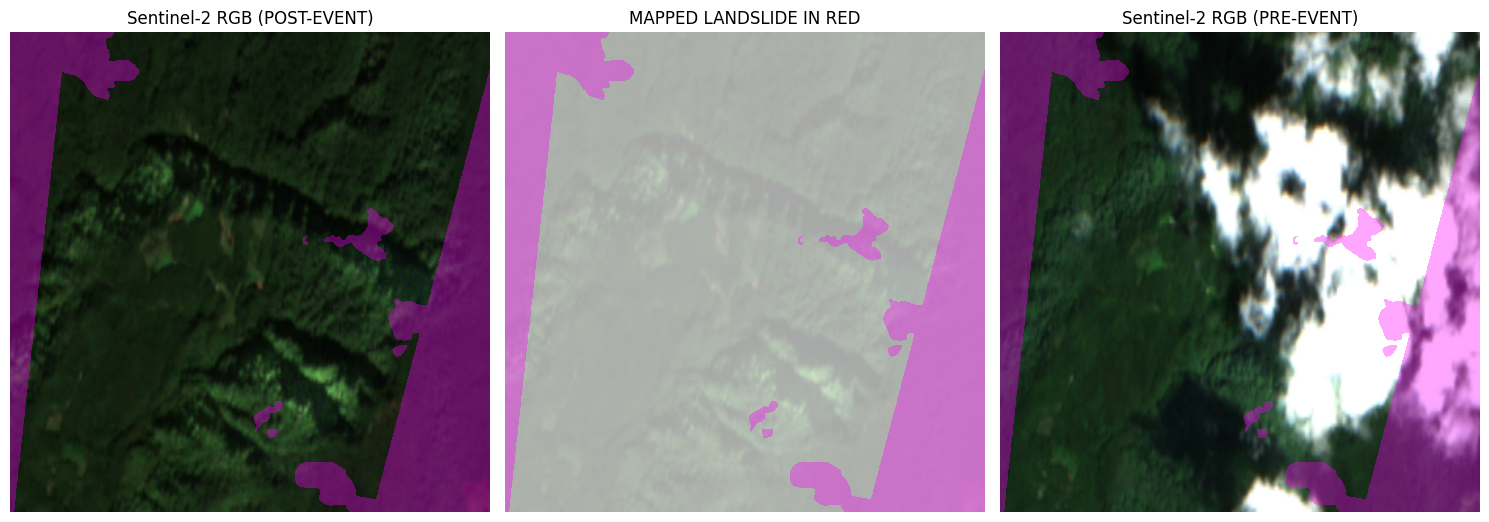

In [ ]:
showMask = True

## Zoom to Extent
xmin, xmax = 0, 1250
ymin, ymax = -2000, -750


LSForDisplay = predictMask_highConf.copy()
LSForDisplay = np.float32(LSForDisplay)
LSForDisplay[LSForDisplay == 0] = np.nan


# display images
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,15))

ax[0].imshow(postImage[ymin:ymax,xmin:xmax])
ax[0].set_title('Sentinel-2 RGB (POST-EVENT)')
ax[0].axis('off')

ax[1].imshow(postImage[ymin:ymax,xmin:xmax], alpha= 0.35)
ax[1].imshow(LSForDisplay[ymin:ymax,xmin:xmax], alpha=1, cmap='bwr', vmin=0, vmax=1)
ax[1].set_title('MAPPED LANDSLIDE IN RED')
ax[1].axis('off')

ax[2].imshow(preImage[ymin:ymax,xmin:xmax])
ax[2].set_title('Sentinel-2 RGB (PRE-EVENT)')
ax[2].axis('off')


if showMask:
    maskForDisplay = 1 - maskImage.copy()
    maskForDisplay = np.float32(maskForDisplay)
    maskForDisplay[maskForDisplay == 0] = np.nan

    ax[0].imshow(maskForDisplay[ymin:ymax,xmin:xmax], alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[1].imshow(maskForDisplay[ymin:ymax,xmin:xmax], alpha=0.35, cmap='cool', vmin=0, vmax=1)
    ax[2].imshow(maskForDisplay[ymin:ymax,xmin:xmax], alpha=0.35, cmap='cool', vmin=0, vmax=1)

fig.tight_layout()
plt.show()